In [1]:
# preprocess of human tonsil reference data and spatial proteomics
# Yuan
# 20241123
# Fig. 3a,c,e

In [17]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import sys
from scipy import stats
import warnings
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Preprocess and visualization of single-cell proteomics data
- Fig. 3a

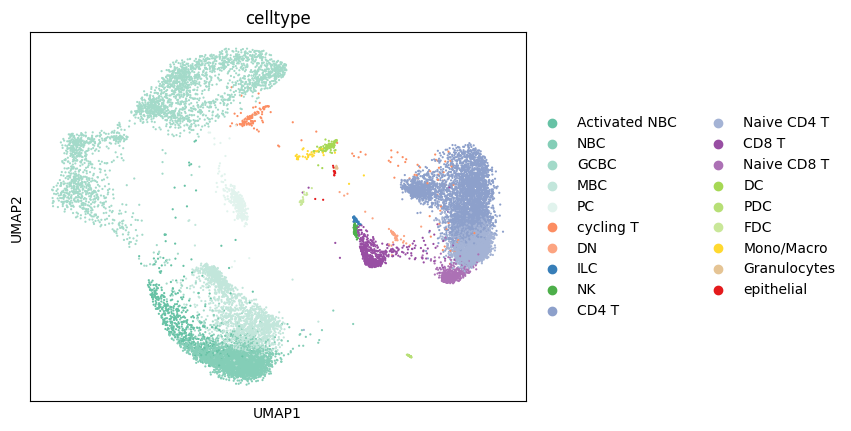

In [5]:
# Preprocess of 2024 HumanTonsil CITE-SEQ data
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023")

sc_adata = sc.read_h5ad("00_raw/20220215_tonsil_atlas_cite_seurat_obj.h5ad")
sc_adata.obsm["X_umap"] = np.array(sc_adata.obs[["UMAP_1_level_1","UMAP_2_level_1"]])
sc_adata = sc_adata[sc_adata.obs.celltype!= "cycling myeloid"].copy()
sc_adata = sc_adata[sc_adata.obs.celltype!= "cycling FDC"].copy()
sc_adata = sc_adata[sc_adata.obs.celltype!= "Mast"].copy()
sc_adata = sc_adata[sc_adata.obs.celltype!= "preB/T"].copy()

sc_adata = sc_adata[sc_adata.obs.subproject == "BCLLATLAS_46"].copy()

sc_adata_var  = pd.read_csv("00_raw/HumanTonsil_sc_var.csv",sep="\t")

sc_adata.var = sc_adata_var

sc_adata.var.index = sc_adata.var.name2

simu_index = ["cell_"+str(i) for i in list(range(1,sc_adata.shape[0]+1))] #设置模拟的spot index
sc_adata.obs.index = simu_index

sc_adata.obs = sc_adata.obs[["celltype","barcode"]]
sc_adata_cp = sc.AnnData(sc_adata.X,obs=sc_adata.obs,var=sc_adata.var)
sc_adata_cp.obs["celltype"] = sc_adata_cp.obs["celltype"].astype("category")# 17367 × 192
# sc_adata_cp.write_h5ad("01_cell_perc/01_data/HumanTonsil_reference_ct19_46.h5ad")

# Fig. 3a, umap of single-cell proteomics 
ct_order = ['Activated NBC','NBC','GCBC','MBC', 'PC', # 5 PC, Plasma cells; B
              'cycling T', 'DN','ILC','NK',#NK   #4 DN, double-negative T cells with a profile of proinflamatory activation
              'CD4 T', 'Naive CD4 T', #2
              'CD8 T','Naive CD8 T',  #2                            
              'DC','PDC', 'FDC',  #3 PDC, plasmactyoid DC; DC
              'Mono/Macro','Granulocytes',  #2 MO
              'epithelial' # 1 Epi and ILC
       ]
sc_adata.obs["celltype"] = sc_adata.obs["celltype"].astype("category")
sc_adata.obs["celltype"] = sc_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)
my_palette = [
    "#66C2A5", "#84CEB7", "#A3DAC9", "#C2E6DB", "#E1F3ED", # B
    "#FC8D62", "#FCA481", 
    "#377EB8",#ILC
     "#4DAF4A",  #NK 
    "#8DA0CB", "#A4B3D5", # T4
    "#984EA3", "#AC71B5", # T8
    "#A6D854", "#B7DF76", "#C9E799",#DC
    "#FFD92F", "#E5C494", #MO and GN
    "#E41A1C", #Epi
    ]
sc.pl.umap(sc_adata, color=["celltype"], size=10,palette=my_palette, save="_HumanTonsil_scp_ref46.pdf")

# Preprocess and visualization of tonsil spatial proteomics data
# - Fig. 3c

In [ ]:
# Preprocess of Spatial-CITE-seq HumanTonsil
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023")
sp_adata = sc.read_h5ad("00_raw/HumanTonsil_Spatial_Count_20230818_282.h5ad")

simu_index = ["spot_"+str(i) for i in list(range(1,sp_adata.shape[0]+1))] #设置模拟的spot index
sp_adata.obs.index = simu_index

sp_adata_var  = pd.read_csv("00_raw/HumanTonsil_sp_var.csv",sep="\t")
sp_adata.var = sp_adata_var
sp_adata_var.index = sp_adata.var["name2"]

# sp_adata.write_h5ad("01_cell_perc/01_data/HumanTonsil_Spatial_2492.h5ad")

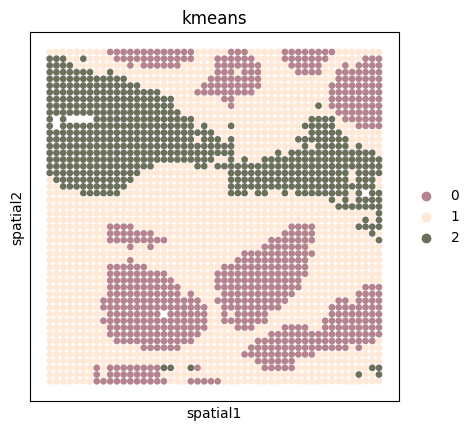

In [16]:
# KMeans analysis
# Fig. 3c
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023")

sp_adata = sc.read_h5ad("01_cell_perc/01_data/HumanTonsil_Spatial_2492.h5ad")

sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)

kmeans = KMeans(n_clusters=3, random_state=42).fit(np.array(sp_adata.to_df()))
sp_adata.obs["true_labels"] = kmeans.labels_.astype(str)
sc.pl.spatial(sp_adata, spot_size=1, color=["true_labels"],title=["kmeans"],palette=['#B5838D','#FFE8D6','#6B705C'],save="_HumanTonsil_clustering_kmeans.pdf") #final decide using this

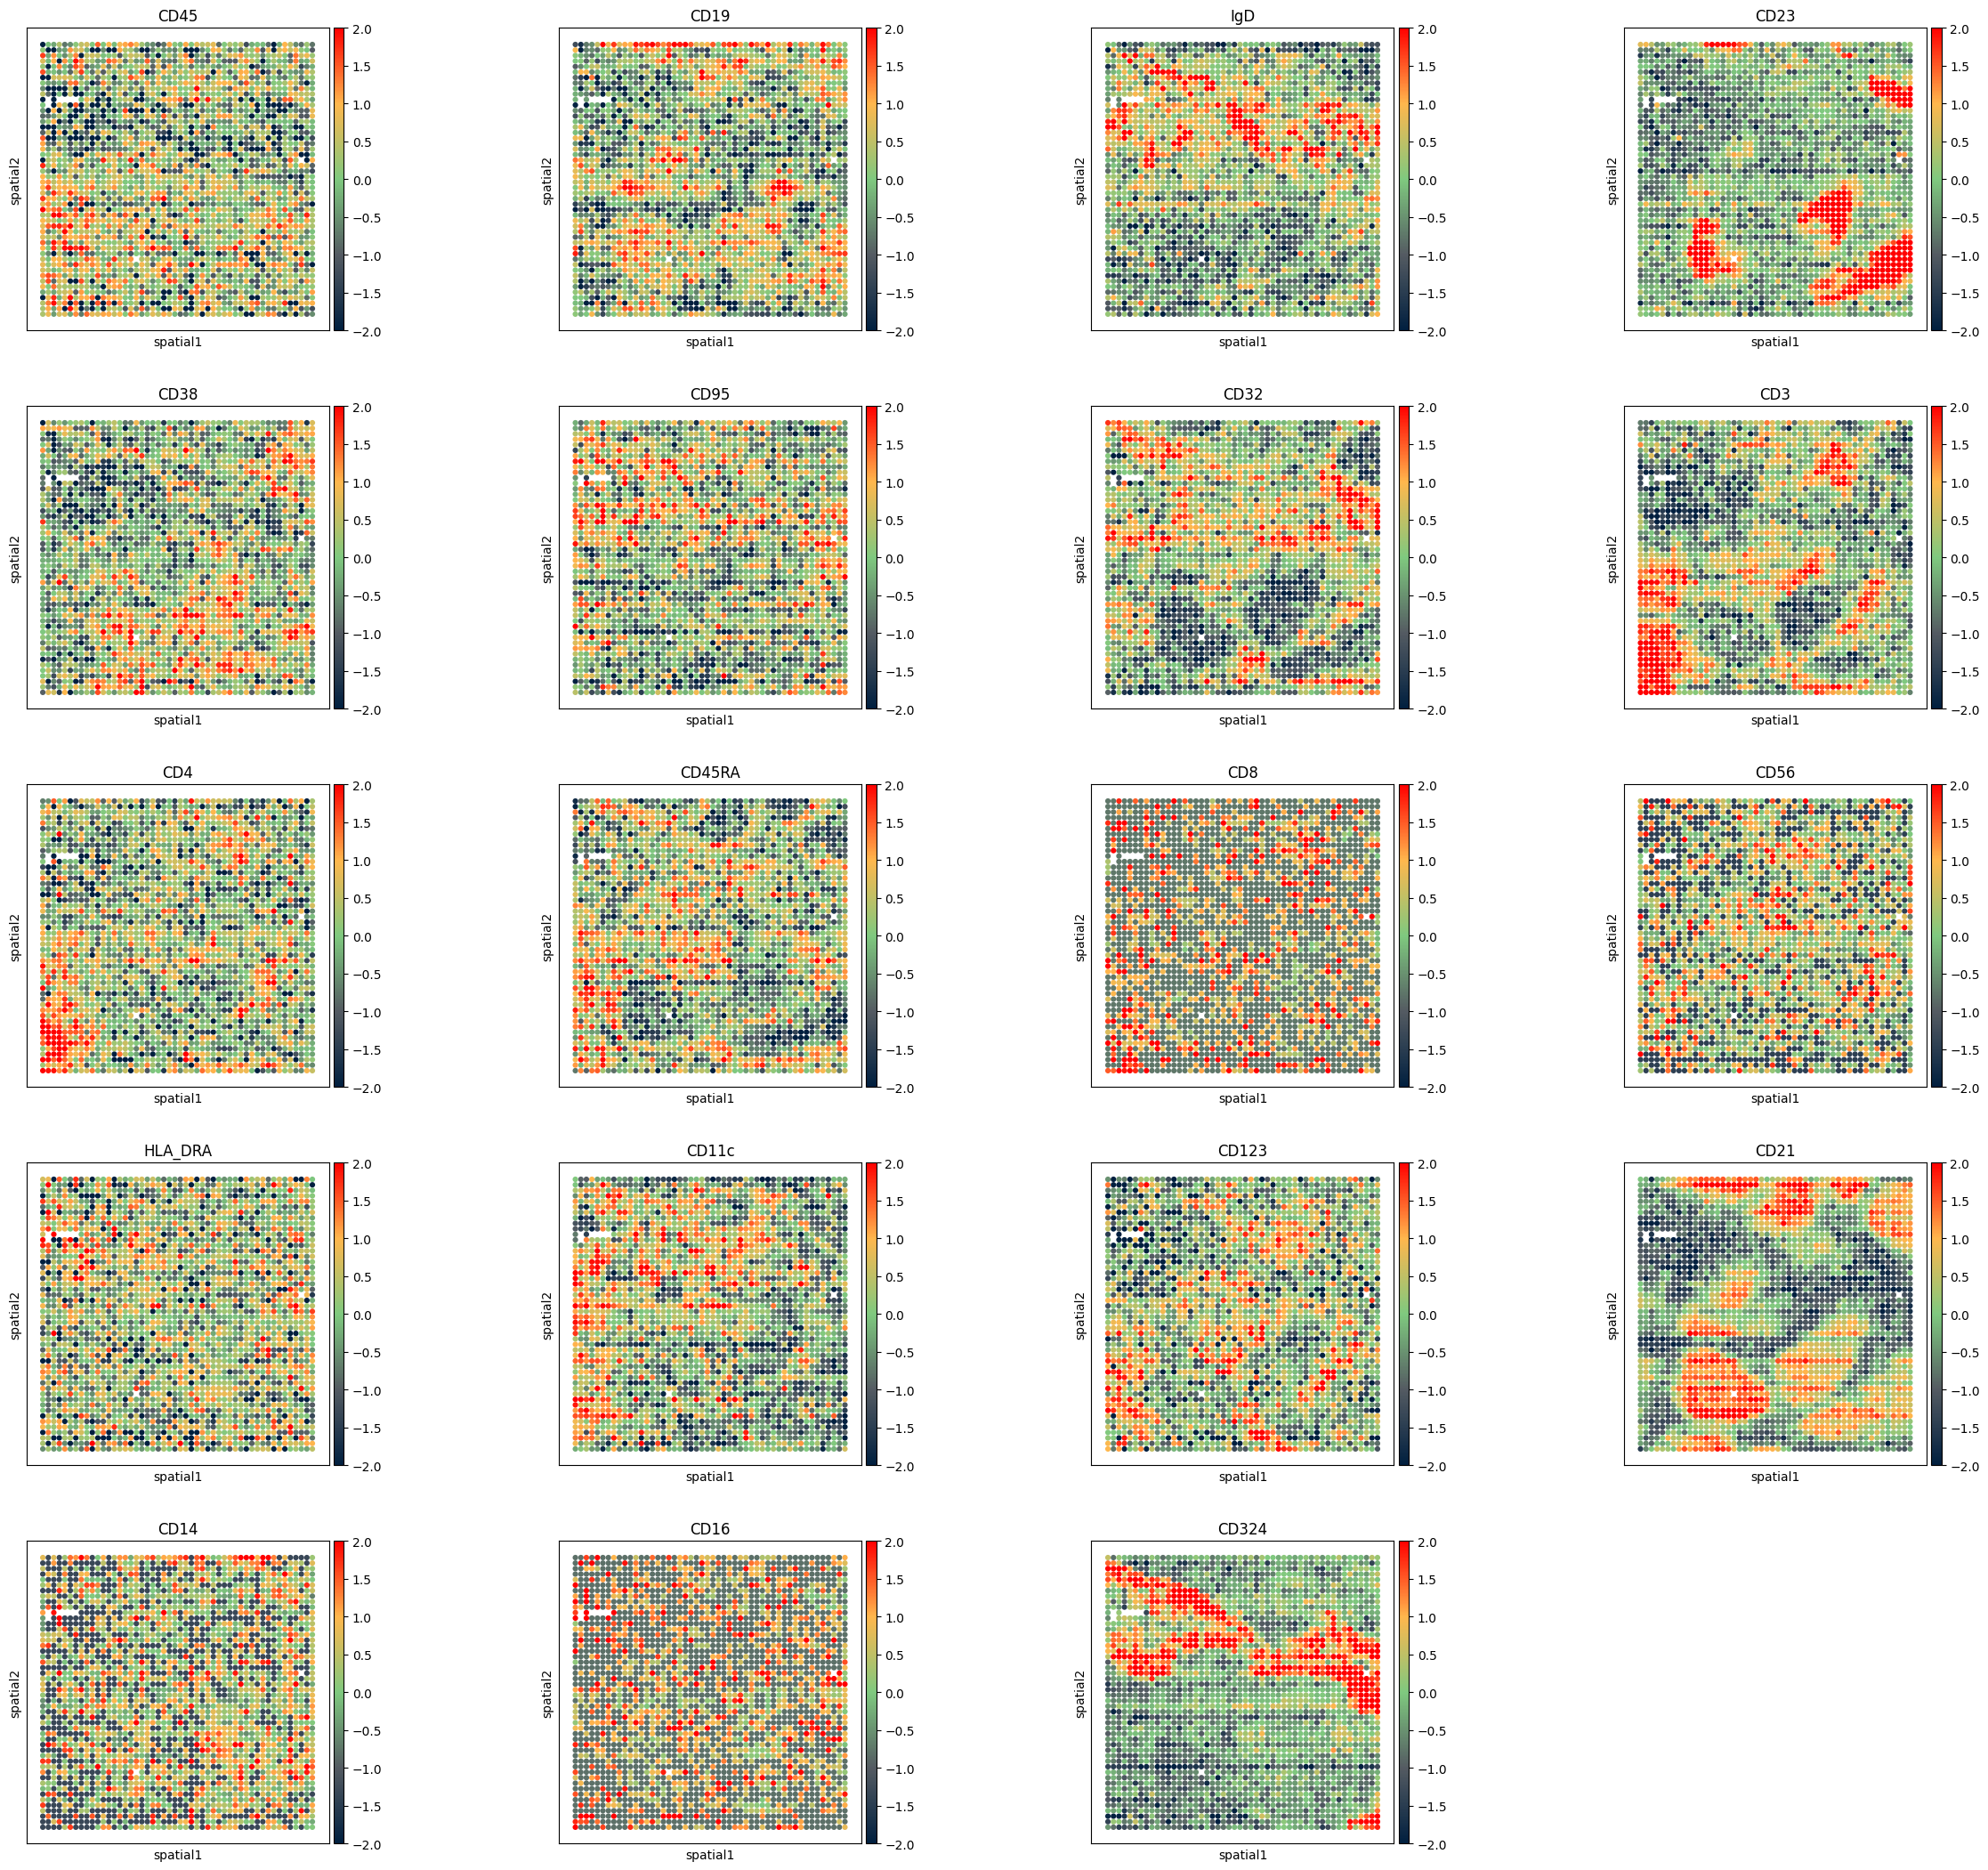

In [18]:
# visualization of known cell-type specific markers
# Fig. 3e
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023")
sp_adata = sc.read_h5ad("01_cell_perc/01_data/HumanTonsil_Spatial_2492.h5ad")

sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)
sc.pp.scale(sp_adata)

colors = ['#001f3f', '#545b62', '#7fc97f', '#ffb74d', 'red']
my_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)

protein_list = [
                "CD45",
                "CD19",#pan-B
                "IgD","CD23",#naive-B,activated naive-B
                "CD38",# "CD77",#GC-B
                "CD95",#"CD27","CD80",#memory-B
                "CD32",#"CD184"#Plasma-B  
                "CD3",#pan-T
                "CD4",#T4
                "CD45RA",#Naive T4
                "CD8",#
                "CD56",#NK
                "HLA_DRA","CD11c","CD123","CD21",#Itgax #DC,Myeloid DC, PDC, FDC
                "CD14","CD16",#MO/MAC
                "CD324",#Epi,CDH1
               ]

sc.pl.spatial(sp_adata,color=protein_list,spot_size=1, color_map=my_cmap,vmin=-2,vmax=2, save="_HumanTonsil_known_markers.pdf")

In [ ]:
# Keep intersected proteins, for comparison of deconvolution methods
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023")
sc_adata = sc.read_h5ad("HumanTonsil_reference_ct19_46.h5ad")
sp_adata = sc.read_h5ad("HumanTonsil_Spatial_2492.h5ad")

pid = np.intersect1d(sc_adata.var.index,sp_adata.var.index) #174 intersected proteins
sc_adata = sc_adata[:,pid].copy()
sp_adata = sp_adata[:,pid].copy()

# sc_adata.write_h5ad("HumanTonsil_reference_ct19_46_intersected.h5ad")
# sp_adata.write_h5ad("HumanTonsil_Spatial_2492_intersected.h5ad")

# for comparision of deconvolution methods
# sp_adata.to_df().to_csv("HumanTonsil_Spatial_2492_intersected_expression.csv")
# sc_adata.to_df().to_csv("HumanTonsil_reference_ct19_46_intersected_expression.csv")

# sc_adata.obs.to_csv("HumanTonsil_reference_ct19_46_intersected_meta.csv")
# sp_adata.obs[["X","Y"]].to_csv("HumanTonsil_Spatial_2492_intersected_spatial.csv")